In [1]:
persons_real_names = [
    "Charles II",
    "Gladys Fleming",
    "Lane Fleming", 
    "Jeff Rand",
    "Arnold Rivers",
    "Carl Gwinnett",
    "Stephen Gresham",
    "Philip Cabot",
    "Nelda Dunmore",
    "Fred Dunmore",
    "Geraldine Varcek",
    "Anton Varcek",
    "Humphrey Goode",
    "Dave Ritter",
    "Mick McKenna",
    "Carter Tipton",
    "Irene Gresham",
    "Dorothy Gresham",
    "Adam Trehearne",
    "Colin MacBride",
    "Pierre Jarrett",
    "Elmer Umholtz",
    "Cecil Gillis",
    "Karen Lawrence",
    "Hester Prynne",
    "Rudolf Hess",
    "Jason Kirchner",
    "Nell Gwyn",
    "Gus Olsen",
    "Jameson",
    "Skinner",
    "Pollard",
    "Dunne",
    "Harry Bentz",
    "Davies",
    "Kathie",
    "Reuben"
]

name_to_replace = {
    # Used format is
    # Regex: replace   

    # To be removed
    "Rifleman": None, 
    "Flemings": None, 
    
    "Colt": None, 
    "Walker": None,
    "Kentuck": None,
    "Mauser": None,
    
    "Rand Dunmore": None, 
    "Rand Pierre": None, 
    
    "Damn": None, 
    "Dammit": None,
    "Premix": None, 
    "Mayflower": None,

    "Mill Pack": None,
    "Fred Hines": None,
    "Sawyer": None, 
    "Hall": None,

    "Plymouth": None, 
    "Farnsworth": None,
    "Science": None,
    "Hitler": None,

    # To be replaced
    
    "Gladys": "Gladys Fleming",
    "Mrs Fleming": "Gladys Fleming",

    "Lane": "Lane Fleming",
    "Mr Fleming": "Lane Fleming",
    
    "Mick": "Mick McKenna",
    "McKenna": "Mick McKenna",

    "Jeff": "Jeff Rand",
    "Rand": "Jeff Rand",
    "Jefferson Davis": "Jeff Rand", 


    "Rivers": "Arnold Rivers",
    "Gwinnett": "Carl Gwinnett",

    "Gresham": "Stephen Gresham",
    
    "Philip": "Philip Cabot",
    "Cabot": "Philip Cabot",

    "Fred": "Fred Dunmore",
    "Frederick Parker Dunmore": "Fred Dunmore",

    "Geraldine": "Geraldine Varcek",
    "Mrs Varcek": "Geraldine Varcek",
    "Varcek": "Anton Varcek",
    "Anton": "Anton Varcek",

    "Humphrey": "Humphrey Goode",
    "Goode": "Humphrey Goode",

    "David Abercrombie Ritter": "Dave Ritter",
    "Dave": "Dave Ritter",

    "Tipton": "Carter Tipton",
    "Trehearne": "Adam Trehearne",
    "Colin": "Colin MacBride",
    "MacBride": "Colin MacBride",
    "Jarrett": "Pierre Jarrett",
    "Umholtz": "Elmer Umholtz",

    "Cecil": "Cecil Gillis",
    "Gillis": "Cecil Gillis",

    "Lawrence": "Karen Lawrence",
    "Karen": "Karen Lawrence",
    "Hester": "Hester Prynne",

    "Aarvo": "Aarvo Kavaalen",
    "Kavaalen": "Aarvo Kavaalen",

    "Kirchner": "Jason Kirchner",
    "Olsen": "Gus Olsen"    

}

In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import community as louvain

from netwulf import visualize

import requests
import re

# TODO python -m spacy download en
import spacy
nlp = spacy.load("en_core_web_sm")

# ---
def get_tag_that_is_chapter(tag): return tag.name == "h2" and tag.contents[0].name == "a"

def tokenize_text(book_text):
    TOKEN_PATTERN = r'\s+'
    regex_wt = nltk.RegexpTokenizer(pattern=TOKEN_PATTERN, gaps=True)
    word_tokens = regex_wt.tokenize(book_text)
    return word_tokens
# ---

# RAW TEXT VERSION

book_num = 17866
book_link = f"https://www.gutenberg.org/ebooks/{book_num}.txt.utf-8"
book_request = requests.get(book_link)

assert book_request.status_code == 200, f"Request of the book failed. Status: {book_request.status_code}"


book_chapters = re.split(r'Chapter [0-9]+', book_request.text, flags=re.IGNORECASE)[1:]
book_chapters[-1] = book_chapters[-1].split("End of Project Gutenberg")[0]

# Warning : indexes start at 1 !
book_chapters_paragraphs = dict()
real_persons_by_chapters = dict()

graph = nx.Graph()

In [3]:
for i, chapter in enumerate(book_chapters):
    i = i+1

    # ---
    # Split and clean up each paragraphs
    chapter_paragraphs = list()
    paragraphs = chapter.split('\r\n\r\n')
    for paragraph in paragraphs:
        clean_paragraph = re.sub(r"[\"\?\!\-\.\,\;\:\(\)\s]+", ' ', paragraph)
        chapter_paragraphs.append(clean_paragraph)

    book_chapters_paragraphs[i] = chapter_paragraphs

    # ---
    # Tag and every detected person's name.
    tokens = nlp(''.join(chapter_paragraphs))
    chapter_persons = [ent.text for ent in tokens.ents if ent.label_ == "PERSON"]
    
    # ---
    # Correct for all possible mentions of a person
    # And remove false positive

    real_chapter_persons = list()
    for person in chapter_persons:
        # If not exactly a real name
        if person not in persons_real_names: 
            # We check if a corresponding name exists
            # Dictionary was made by hand
            for k,v in name_to_replace.items():
                reg = re.compile(k)
                # If something match
                if reg.match(person):
                    # We don't count as it's not a person's name 
                    if v is None: break 
                    # Or replace it by the correct one
                    real_chapter_persons.append(v)
        else: real_chapter_persons.append(person)

    unique_real_chapter_persons = list(set(real_chapter_persons))
    real_persons_by_chapters[i] = unique_real_chapter_persons

    # ---
    # Add to the graph
    # Edges for each people in a chapter (?)

    graph.add_nodes_from(unique_real_chapter_persons)
    for idx in range(len(unique_real_chapter_persons)-1):
        graph.add_edge(unique_real_chapter_persons[idx], unique_real_chapter_persons[idx-1])

No handles with labels found to put in legend.


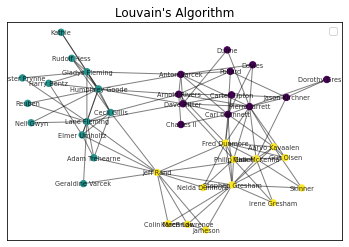

In [41]:
# ---
# Louvain Algorithm
# https://github.com/taynaud/python-louvain

partition = louvain.best_partition(graph)

# draw the graph
pos = nx.spring_layout(graph)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(graph, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(graph, pos, alpha=0.5)
nx.draw_networkx_labels(graph, pos, {n: n for n in partition}, font_size=6.5, alpha = 0.8)
plt.title("Louvain's Algorithm")
plt.show()

In [5]:
print(real_persons_by_chapters.get(1))

['Anton Varcek', 'Humphrey Goode', 'Nell Gwyn', 'Lane Fleming', 'Geraldine Varcek', 'Jeff Rand', 'Stephen Gresham', 'Nelda Dunmore', 'Philip Cabot', 'Fred Dunmore', 'Carl Gwinnett', 'Charles II', 'Arnold Rivers', 'Gladys Fleming']
